In [1]:
import yfinance as yf #type: ignore
import pandas as pd #type: ignore
import numpy as np #type: ignore
import matplotlib.pyplot as plt #type: ignore
import seaborn as sns #type: ignore
import plotly.express as px #type: ignore
import plotly.graph_objs as go #type: ignore
import itertools
import pandas_ta as ta

In [2]:
def missing_data(input_data):
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum() / input_data.isnull().count() * 100).round(1)
    table = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    for col in input_data.columns:
        dtype = input_data[col].dtype
        table.loc['Types'] = dtype
    return table
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual) * 100)


In [3]:
# Get the historical data for Ethereum
eth_data = yf.Ticker("ETH-USD").history(period="max")

# Extract the Date and the Open, Close, Low, High prices
eth_prices = eth_data[['Open', 'Close', 'Low', 'High']]
eth_prices.reset_index(inplace=True)
eth_prices['Date'] = pd.to_datetime(eth_prices['Date'])
eth_prices['Date'] = eth_prices['Date'].dt.tz_localize(None)

eth_prices.head()


C:\Users\DELL\AppData\Local\Temp\ipykernel_10996\3471832956.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_prices['Date'] = pd.to_datetime(eth_prices['Date'])
C:\Users\DELL\AppData\Local\Temp\ipykernel_10996\3471832956.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_prices['Date'] = eth_prices['Date'].dt.tz_localize(None)


,Date,Open,Close,Low,High
0,2017-11-09,308.644989,320.884003,307.056000,329.451996
1,2017-11-10,320.670990,299.252991,294.541992,324.717987
2,2017-11-11,298.585999,314.681000,298.191986,319.453003
3,2017-11-12,314.690002,307.907990,298.513000,319.153015
4,2017-11-13,307.024994,316.716003,307.024994,328.415009


In [4]:
eth_prices['7-day'] = eth_prices['Close'].rolling(7).mean()
eth_prices['21-day'] = eth_prices['Close'].rolling(21).mean()
eth_prices['signal'] = np.where(eth_prices['7-day'] > eth_prices['21-day'], 1, 0)
eth_prices['signal'] = np.where(eth_prices['7-day'] < eth_prices['21-day'], -1, eth_prices['signal'])
eth_prices['entry'] = eth_prices.signal.diff()

C:\Users\DELL\AppData\Local\Temp\ipykernel_10996\2992706385.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_prices['7-day'] = eth_prices['Close'].rolling(7).mean()


In [5]:
missing_data(eth_prices)

,Total,Percent
Date,0,0.0
Open,0,0.0
Close,0,0.0
Low,0,0.0
High,0,0.0
7-day,6,0.3
21-day,20,0.9
signal,0,0.0
entry,1,0.0
Types,float64,float64


In [6]:
import mplfinance as mpf #type: ignore

In [7]:
eth_prices_2021 = eth_prices[eth_prices['Date'] >= '2021-01-01']
eth_prices_2021

,Date,Open,Close,Low,High,7-day,21-day,signal,entry
1149,2021-01-01,737.708374,730.367554,719.792236,749.201843,714.312221,649.125660,1,0.0
1150,2021-01-02,730.402649,774.534973,718.109497,786.798462,734.126386,658.933643,1,0.0
1151,2021-01-03,774.511841,975.507690,771.561646,1006.565002,775.964294,677.307190,1,0.0
1152,2021-01-04,977.058838,1040.233032,912.305359,1153.189209,820.226536,698.936802,1,0.0
1153,2021-01-05,1041.498779,1100.006104,986.811279,1129.371460,872.867388,723.253494,1,0.0
...,...,...,...,...,...,...,...,...,...
2317,2024-03-14,4005.745117,3883.140381,3721.788574,4011.102783,3946.426967,3572.854120,1,0.0
2318,2024-03-15,3882.856934,3735.220215,3571.774658,3928.775635,3924.021136,3611.595168,1,0.0
2319,2024-03-16,3736.104980,3522.860107,3468.079346,3780.894531,3867.941302,3636.855841,1,0.0
2320,2024-03-17,3523.029785,3642.413086,3414.172363,3676.263428,3833.829869,3662.080404,1,0.0


# Moving Average Crossover (MAC)(21,7)
   - **Explanation**: This signal identifies a potential change in trend direction when a short-term moving average crosses above or below a longer-term moving average.
   - **Formula**:
     - For a bullish crossover (indicating a potential uptrend): \( MA_{short} > MA_{long} \)
     - For a bearish crossover (indicating a potential downtrend): \( MA_{short} < MA_{long} \)
     - Where:
       - \( MA_{short} \) = Value of the short-term moving average (e.g., 20-period SMA)
       - \( MA_{long} \) = Value of the long-term moving average (e.g., 50-period SMA)

In [8]:
def signals(data):
    buy_signals = [np.nan] * len(data) 
    sell_signals = [np.nan] * len(data)
    a= 0
    for i in data.index:
        if data.loc[i, 'entry'] == 2: 
            buy_signals[a] = data.loc[i, 'Close']
        elif data.loc[i, 'entry'] == -2:
            sell_signals[a] = data.loc[i, 'Close']
        a += 1
    return buy_signals, sell_signals

buy_signals ,sell_signals = signals(eth_prices_2021)

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


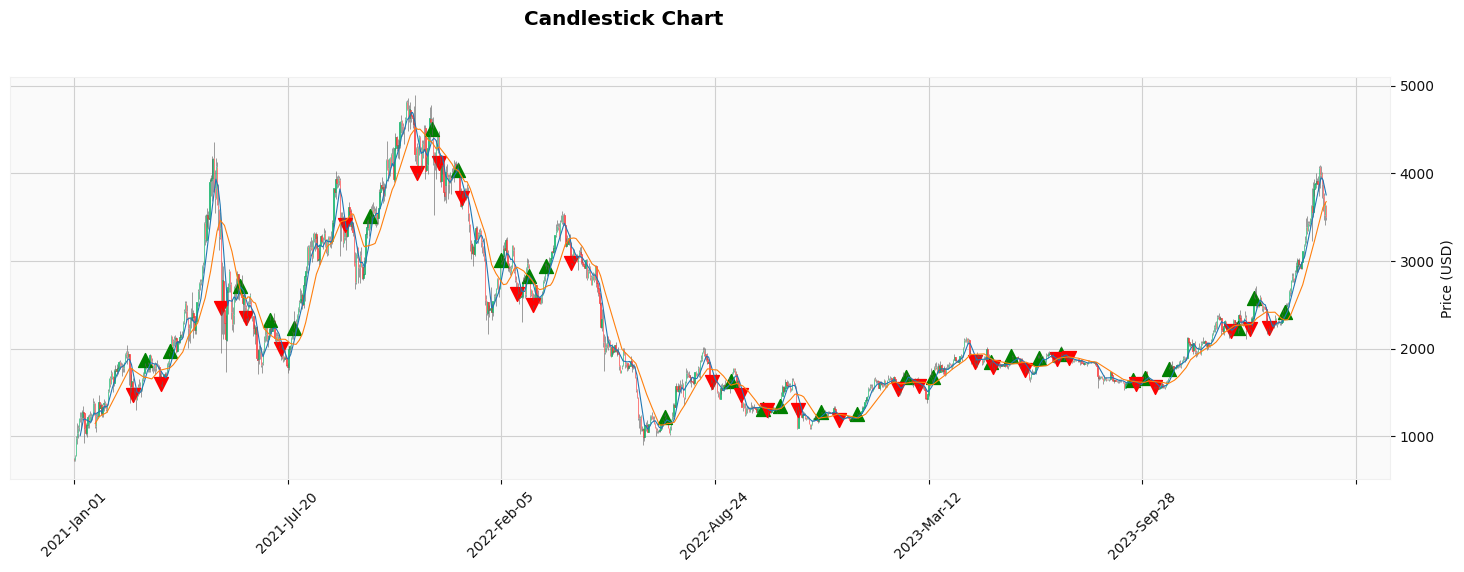

In [9]:
buy_signals ,sell_signals = signals(eth_prices_2021)

# Create mpf plot
mpf.plot(eth_prices_2021.set_index("Date"),
         type='candle', style='yahoo', title='Candlestick Chart', 
         ylabel='Price (USD)', mav=(7,21), figratio=(20,6),
         addplot=[
             mpf.make_addplot(buy_signals, type='scatter', marker='^', markersize=100, color='g'),
             mpf.make_addplot(sell_signals, type='scatter', marker='v', markersize=100, color='r')
         ]
)


# Relative Strength Index (RSI)(14)
- **Explanation**: RSI measures the magnitude of recent price changes to evaluate overbought or oversold conditions in a market.
   - **Formula**:
     - $ RSI = 100 - \frac{100}{1 + RS} $
     - Where:
       - \( RS \) (Relative Strength) = $\frac{Average Gain}{Average Loss}$ over a specified period
       - Average Gain = Average of price gains over the specified period
       - Average Loss = Average of price losses over the specified period

In [10]:
rsi_period = 14  # You can adjust this period as needed
eth_prices_2021["RSI"] = ta.rsi(eth_prices_2021["Close"], length=rsi_period)

C:\Users\DELL\AppData\Local\Temp\ipykernel_10996\2370997124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_prices_2021["RSI"] = ta.rsi(eth_prices_2021["Close"], length=rsi_period)


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


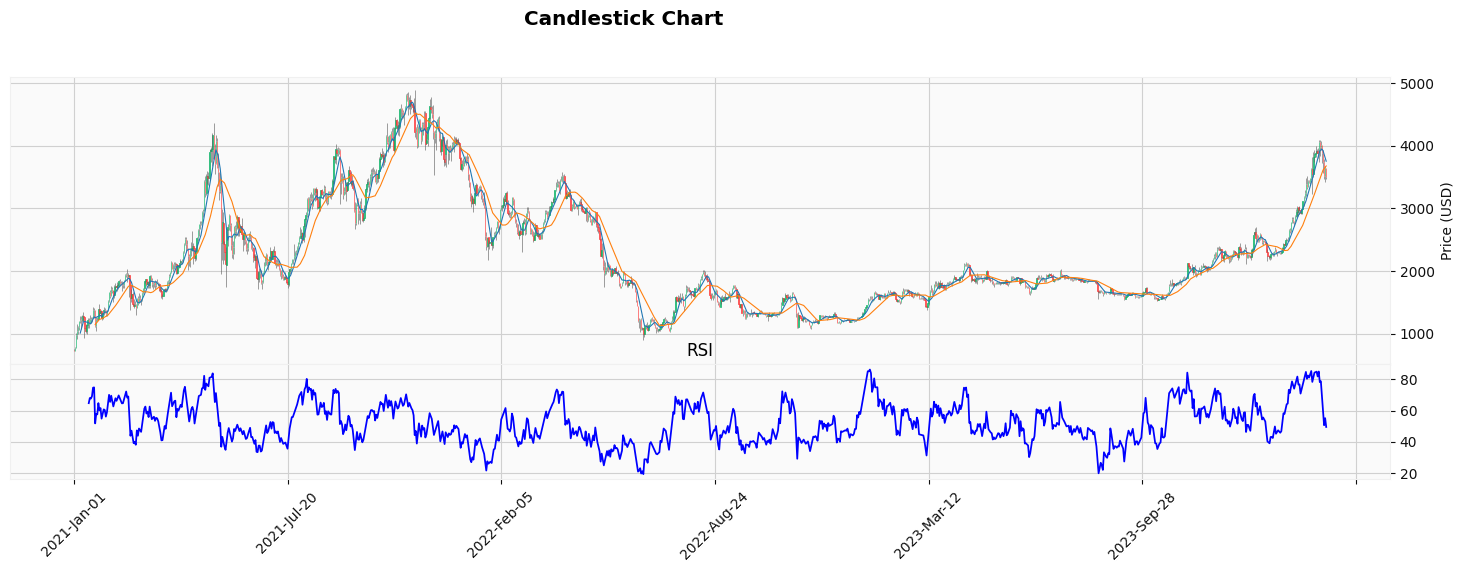

In [11]:
mpf.plot(eth_prices_2021.set_index("Date"),
         type='candle', style='yahoo', title='Candlestick Chart', 
         ylabel='Price (USD)', mav=(7,21), figratio=(20,6),
            addplot=[
                mpf.make_addplot(eth_prices_2021["RSI"], panel=1, color='b', title='RSI')
            ])

# MACD (Moving Average Convergence Divergence)
- **Explanation**: MACD is a trend-following momentum indicator that shows the relationship between two moving averages of a security’s price.
   - **Formula**:
     - MACD Line = 12-period EMA - 26-period EMA
     - Signal Line = 9-period EMA of MACD Line
     - Histogram = MACD Line - Signal Line

In [ ]:
MACD =ta.macd(eth_prices_2021["Close"], fast=12, slow=26, signal=9) # type: ignore
eth_prices_2021["MACD_12"] = MACD.iloc[:,0] # type: ignore
eth_prices_2021["MACD_26"] = MACD.iloc[:,1] # type: ignore
eth_prices_2021["MACD_9"] = MACD.iloc[:,2] # type: ignore


In [30]:
eth_prices_2021

,Date,Open,Close,Low,High,7-day,21-day,signal,entry,RSI,MACD_12,MACD_26,MACD_9
1149,2021-01-01,737.708374,730.367554,719.792236,749.201843,714.312221,649.125660,1,0.0,0.000000,NaN,NaN,NaN
1150,2021-01-02,730.402649,774.534973,718.109497,786.798462,734.126386,658.933643,1,0.0,0.000000,NaN,NaN,NaN
1151,2021-01-03,774.511841,975.507690,771.561646,1006.565002,775.964294,677.307190,1,0.0,0.000000,NaN,NaN,NaN
1152,2021-01-04,977.058838,1040.233032,912.305359,1153.189209,820.226536,698.936802,1,0.0,0.000000,NaN,NaN,NaN
1153,2021-01-05,1041.498779,1100.006104,986.811279,1129.371460,872.867388,723.253494,1,0.0,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2317,2024-03-14,4005.745117,3883.140381,3721.788574,4011.102783,3946.426967,3572.854120,1,0.0,69.739926,297.765195,2.589660,295.175535
2318,2024-03-15,3882.856934,3735.220215,3571.774658,3928.775635,3924.021136,3611.595168,1,0.0,60.746897,270.155601,-20.015947,290.171548
2319,2024-03-16,3736.104980,3522.860107,3468.079346,3780.894531,3867.941302,3636.855841,1,0.0,50.649102,228.505049,-49.333199,277.838248
2320,2024-03-17,3523.029785,3642.413086,3414.172363,3676.263428,3833.829869,3662.080404,1,0.0,55.167340,202.805793,-60.025964,262.831757


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


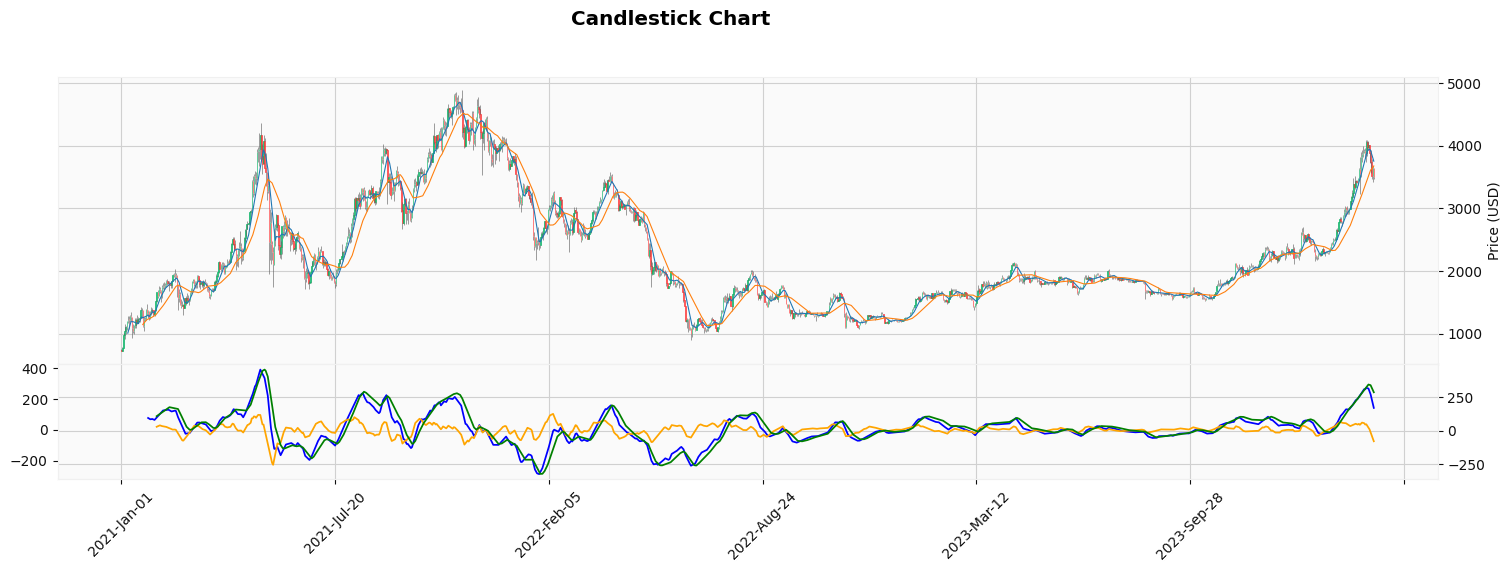

In [33]:
# Plot candlestick chart with MACD
mpf.plot(eth_prices_2021.set_index("Date"),
         type='candle', style='yahoo', title='Candlestick Chart', 
         ylabel='Price (USD)', mav=(7, 21), figratio=(20, 6),
         addplot=[mpf.make_addplot(eth_prices_2021["MACD_12"], panel=1, color='blue'),
                  mpf.make_addplot(eth_prices_2021["MACD_26"], panel=1, color='orange'),
                  mpf.make_addplot(eth_prices_2021["MACD_9"], panel=1, color='green')])

# Bollinger Bands
- **Explanation**: Bollinger Bands consist of a middle band (simple moving average) and two outer bands (standard deviations away from the middle band). They help identify overbought or oversold conditions.
   - **Formula**:
     - Middle Band = $n_{period-SMA}$
     - Upper Band = $Middle Band + k * n_{period-standard-deviation}$
     - Lower Band = $Middle Band - k * n_{period-standard-deviation}$
     - Where:
       - \( n \) = Number of periods (e.g., 20)
       - \( k \) = Number of standard deviations (typically 2)

In [36]:
eth_prices_2021["Middle Band"]= eth_prices_2021["Close"].rolling(window=20).mean()
eth_prices_2021["Upper Band"] = eth_prices_2021["Middle Band"] + 2*eth_prices_2021["Close"].rolling(window=20).std()
eth_prices_2021["Lower Band"] = eth_prices_2021["Middle Band"] - 2*eth_prices_2021["Close"].rolling(window=20).std()

C:\Users\DELL\AppData\Local\Temp\ipykernel_10996\1453520421.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_prices_2021["Middle Band"]= eth_prices_2021["Close"].rolling(window=20).mean()
C:\Users\DELL\AppData\Local\Temp\ipykernel_10996\1453520421.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_prices_2021["Upper Band"] = eth_prices_2021["Middle Band"] + 2*eth_prices_2021["Close"].rolling(window=20).std()
C:\Users\DELL\AppData\Local\Temp\ipykernel_10996\1453520421.py:3: SettingWithCopyWarning

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


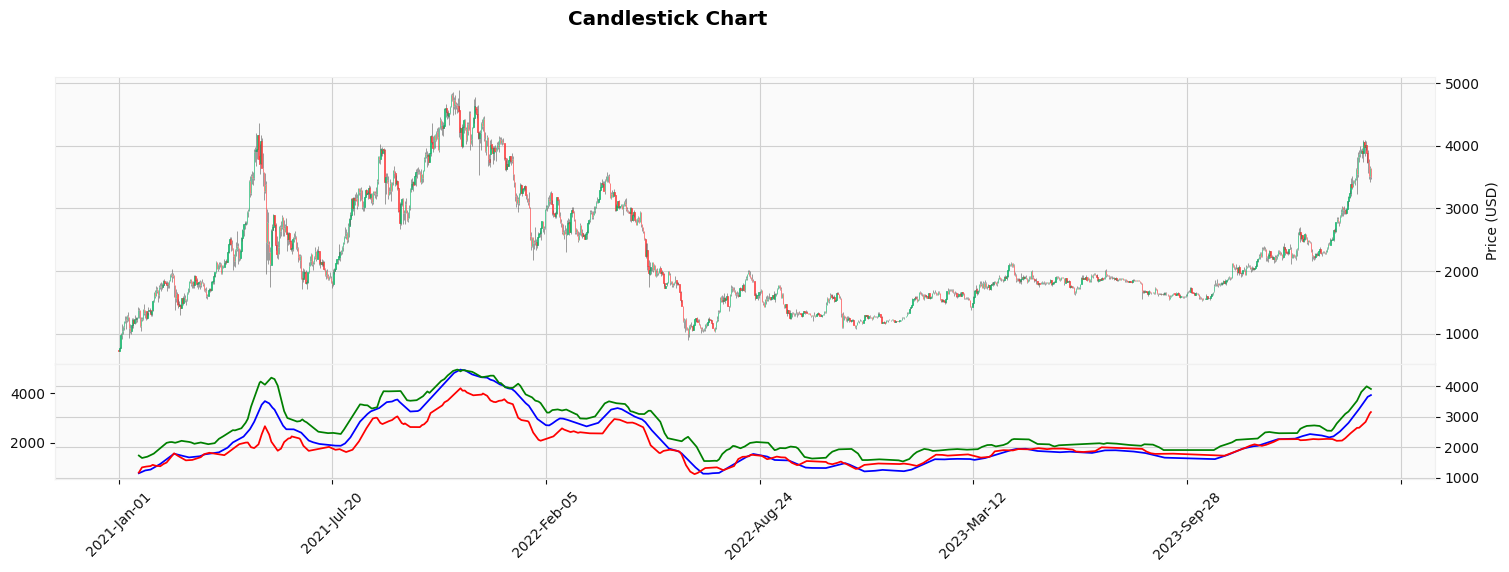

In [38]:
mpf.plot(eth_prices_2021.set_index("Date"),
         type='candle', style='yahoo', title='Candlestick Chart', 
         ylabel='Price (USD)', figratio=(20,6),
            addplot=[
                mpf.make_addplot(eth_prices_2021["Middle Band"], panel=1, color='b'),
                mpf.make_addplot(eth_prices_2021["Upper Band"], panel=1, color='g'),
                mpf.make_addplot(eth_prices_2021["Lower Band"], panel=1, color='r')
            ])

# Stochastic Oscillator
- **Explanation**: The Stochastic Oscillator compares a security's closing price to its price range over a specified period to generate signals based on overbought and oversold conditions.
   - **Formula**:
     - $ \%K = \frac{Close - Lowest\_low}{Highest\_high - Lowest\_low} \times 100 $
     - $ \%D = n_{period-moving-average} of \%K $
     - Where:
       - \( \%K \) = Stochastic %K value
       - \( \%D \) = Stochastic %D value
       - \( n \) = Number of periods (e.g., 14)

In [41]:
Oscillator =ta.stoch(eth_prices_2021["High"], eth_prices_2021["Low"], eth_prices_2021["Close"], window=14) # type: ignore
eth_prices_2021["STOCHk"] = Oscillator.iloc[:,0] # type: ignore
eth_prices_2021["STOCHd"] = Oscillator.iloc[:,1] # type: ignore

C:\Users\DELL\AppData\Local\Temp\ipykernel_10996\2740137866.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_prices_2021["STOCHk"] = Oscillator.iloc[:,0] # type: ignore
C:\Users\DELL\AppData\Local\Temp\ipykernel_10996\2740137866.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eth_prices_2021["STOCHd"] = Oscillator.iloc[:,1] # type: ignore


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


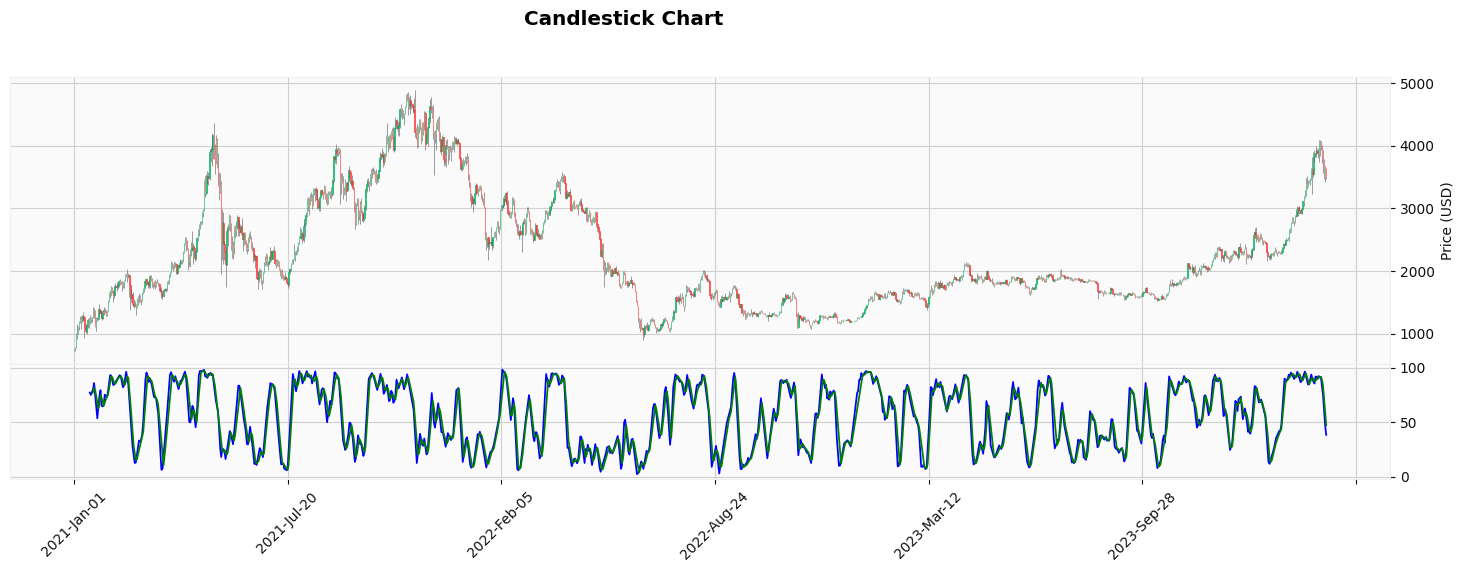

In [42]:
mpf.plot(eth_prices_2021.set_index("Date"),
         type='candle', style='yahoo', title='Candlestick Chart', 
         ylabel='Price (USD)', figratio=(20,6),
            addplot=[
                mpf.make_addplot(eth_prices_2021["STOCHk"], panel=1, color='b'),
                mpf.make_addplot(eth_prices_2021["STOCHd"], panel=1, color='g')
            ])

In [11]:
from prophet import Prophet #type: ignore

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
Eth = eth_prices[['Date', 'avg']].rename(columns={'Date': 'ds', 'avg': 'y'})
Days_To_predict = 15

Train,Test = Eth.iloc[:-Days_To_predict], Eth.iloc[-Days_To_predict:]

In [13]:
model = Prophet()
model.fit(Train)  # Only pass the DataFrame with 'ds' and 'y'

# If you want to make predictions, you'll need to create a future DataFrame
future = model.make_future_dataframe(periods=len(Test))
forecast = model.predict(future)

17:37:09 - cmdstanpy - INFO - Chain [1] start processing
17:37:11 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()


,ds,yhat,yhat_lower,yhat_upper
0,2017-11-09,789.005940,465.345925,1102.268985
1,2017-11-10,774.327862,460.862998,1092.862957
2,2017-11-11,765.165280,446.848518,1087.101931
3,2017-11-12,756.583891,438.012320,1098.579036
4,2017-11-13,744.288464,429.650970,1072.989977


c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


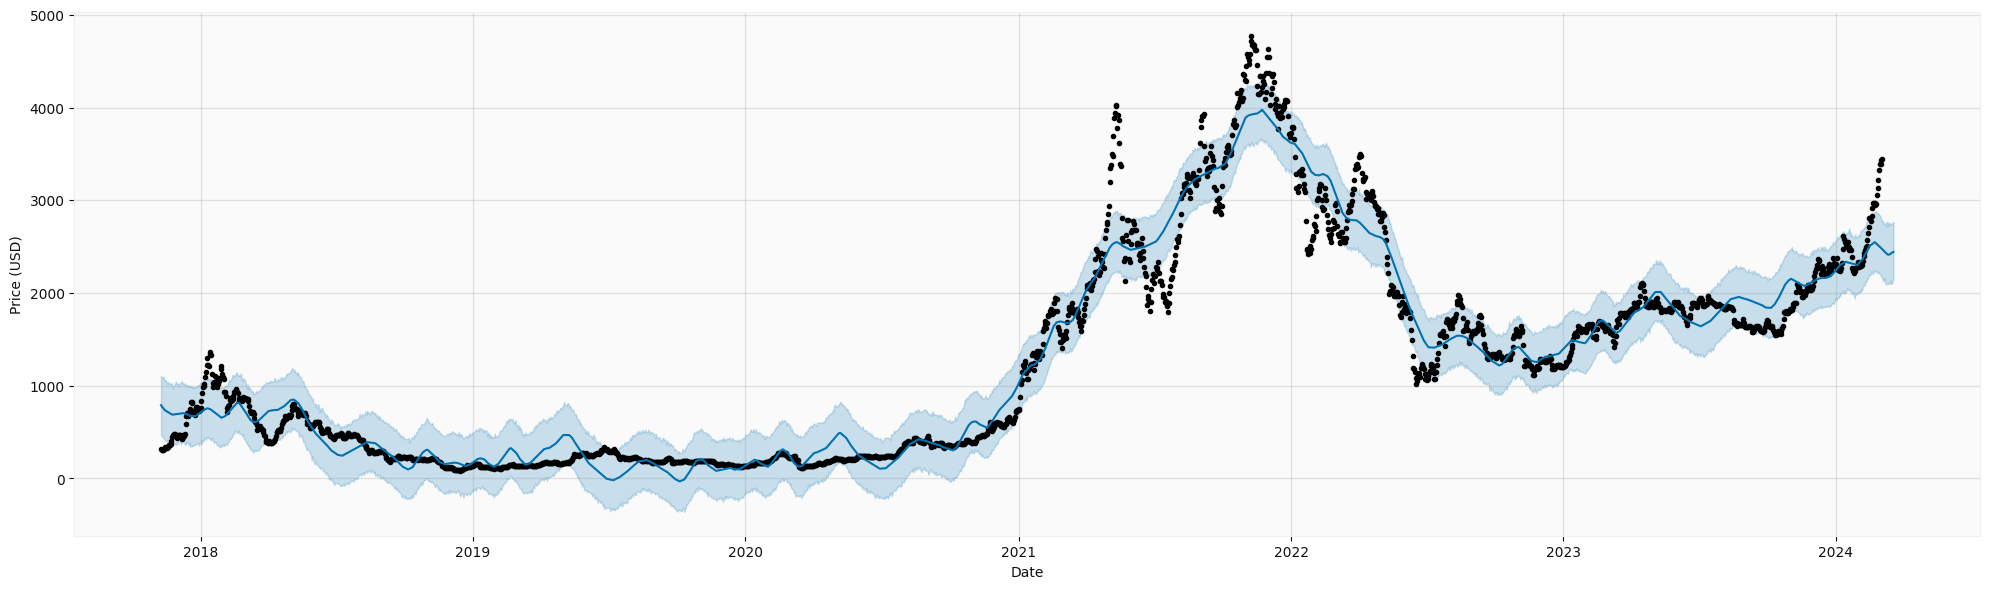

In [15]:
fig = model.plot(forecast, xlabel='Date', ylabel='Price (USD)', figsize=(20,6), uncertainty=True, plot_cap=True,)

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series contain

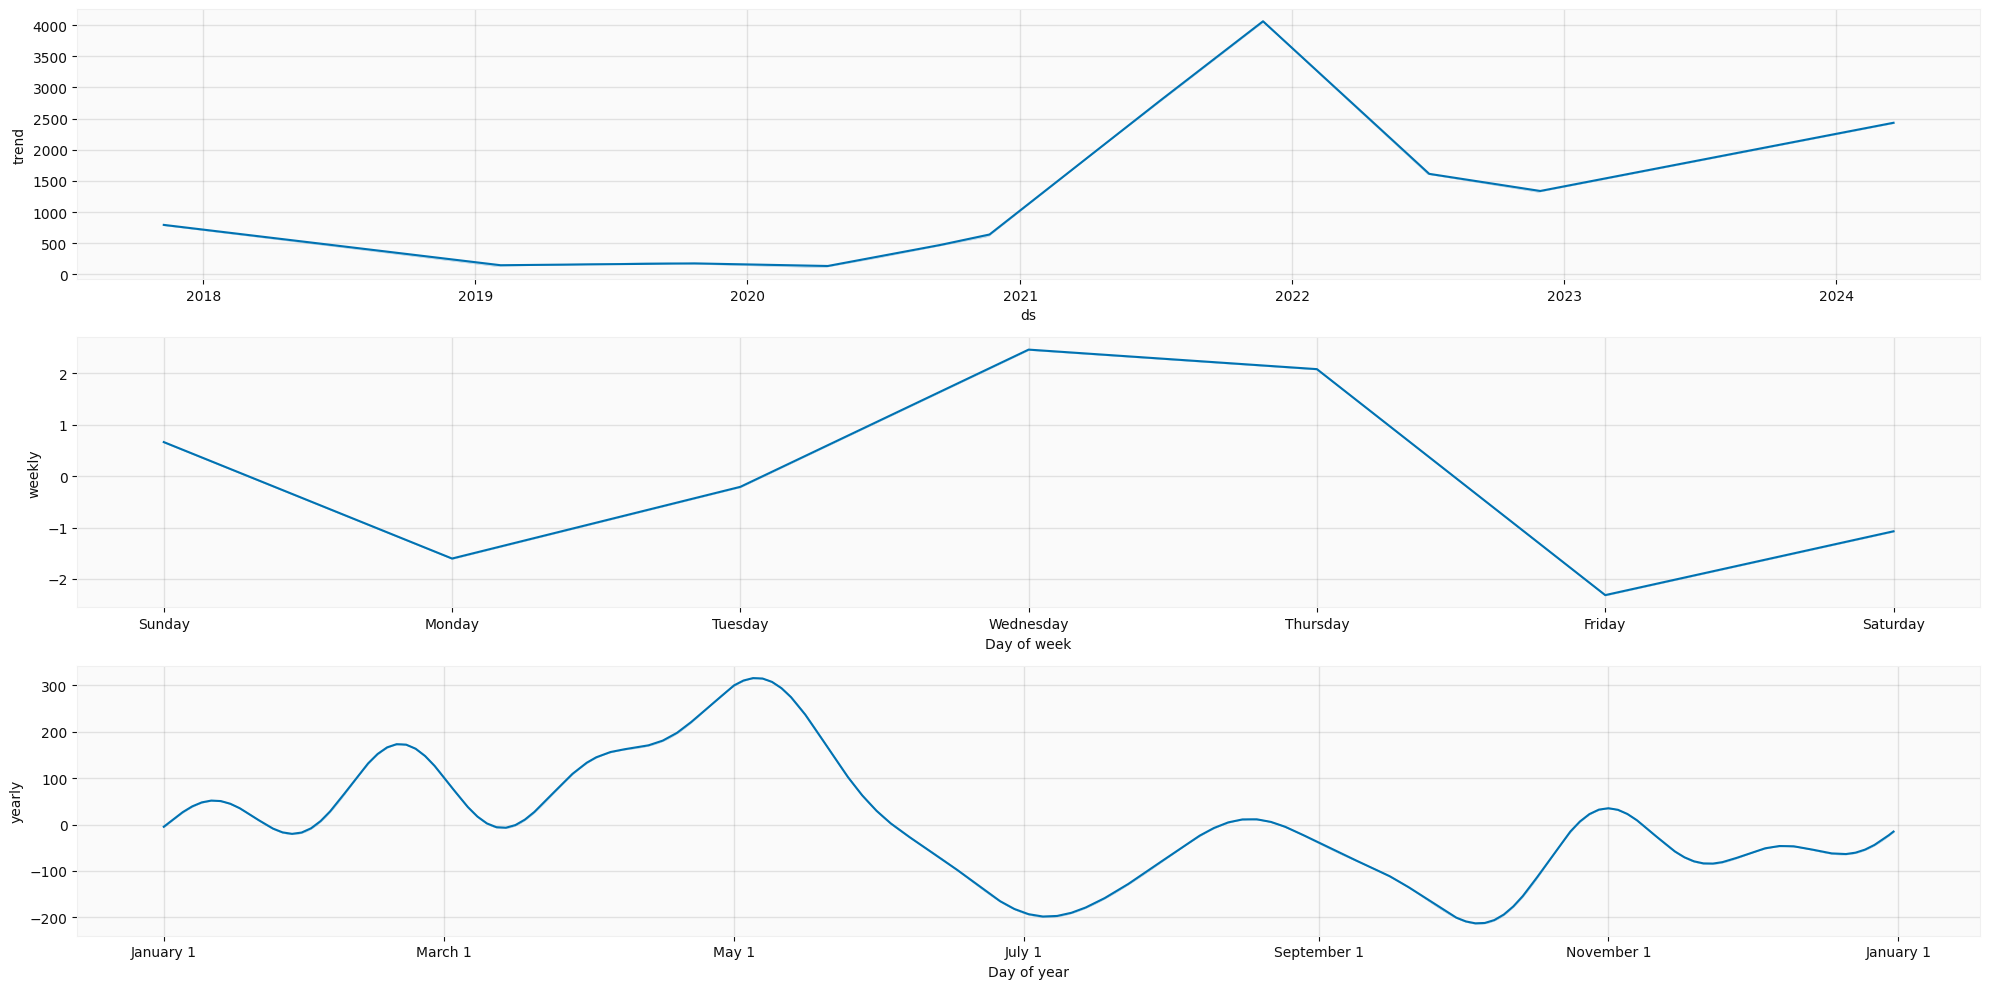

In [16]:
fig2 = model.plot_components(forecast, figsize=(20,10))

In [17]:
filter = forecast['ds'] > Train['ds'].iloc[-1]
forecast1 = forecast[filter][['ds', 'yhat']]
True_Predict = pd.concat([forecast1, Test['y']], axis=1)

In [18]:
True_Predict = True_Predict.rename(columns={'ds': 'Date', 'yhat': 'Predicted Price','y' : 'Actual Price'})

In [19]:
mape(True_Predict['Actual Price'], True_Predict['Predicted Price'])

35.655612669774676

In [20]:
from prophet.diagnostics import cross_validation #type: ignore
df_cv = cross_validation(model, initial='1500 days', period='15 days', horizon = '15 days')

  0%|          | 0/53 [00:00<?, ?it/s]17:37:17 - cmdstanpy - INFO - Chain [1] start processing
17:37:18 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/53 [00:01<01:43,  1.99s/it]17:37:19 - cmdstanpy - INFO - Chain [1] start processing
17:37:19 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 2/53 [00:02<01:03,  1.25s/it]17:37:19 - cmdstanpy - INFO - Chain [1] start processing
17:37:20 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 3/53 [00:03<00:55,  1.11s/it]17:37:20 - cmdstanpy - INFO - Chain [1] start processing
17:37:21 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 4/53 [00:04<00:49,  1.00s/it]17:37:21 - cmdstanpy - INFO - Chain [1] start processing
17:37:22 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 5/53 [00:05<00:50,  1.06s/it]17:37:22 - cmdstanpy - INFO - Chain [1] start processing
17:37:23 - cmdstanpy - INFO - Chain [1] done processing
 11%|█▏        | 6/53 [00:06<00:48,  1.02s/it]17:37:23

KeyboardInterrupt: 

In [ ]:
from prophet.diagnostics import performance_metrics #type: ignore
performance_metrics(df_cv)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,2 days,426460.359296,653.039324,519.903463,0.277434,0.222887,0.278294,0.383568
1,3 days,452120.158285,672.398809,532.922185,0.287345,0.238782,0.285579,0.402675
2,4 days,466236.277696,682.814966,542.253040,0.294466,0.240684,0.291526,0.402436
3,5 days,470711.889384,686.084462,549.626160,0.300102,0.218843,0.297384,0.396226
4,6 days,468711.108117,684.624794,549.835109,0.300694,0.254157,0.299225,0.383568
5,7 days,473617.606254,688.198813,551.956662,0.302016,0.257737,0.302236,0.377358
6,8 days,508750.985233,713.267822,570.492326,0.312843,0.238042,0.312573,0.364700
7,9 days,549840.167783,741.512082,589.855042,0.324287,0.292956,0.322603,0.345832
8,10 days,566683.802437,752.784034,600.030686,0.327279,0.283447,0.327490,0.352281
9,11 days,597213.685669,772.796018,615.211609,0.329914,0.306469,0.332572,0.345832


In [ ]:
param_grid = {  
    'changepoint_range':[0.8,0.83,0.86,0.89,0.92,0.95]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(Train)  # Fit model with given params
    df_cv = cross_validation(m, initial='1500 days', period='15 days', horizon = '15 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results

In [ ]:
best_params = {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive' , 'changepoint_range':0.95}

In [ ]:
model = Prophet(**best_params)
model.fit(Train)  # Only pass the DataFrame with 'ds' and 'y'

# If you want to make predictions, you'll need to create a future DataFrame
future = model.make_future_dataframe(periods=len(Test))
forecast = model.predict(future)
filter = forecast['ds'] > Train['ds'].iloc[-1]
forecast1 = forecast[filter][['ds', 'yhat']]
True_Predict = pd.concat([forecast1, Test['y']], axis=1)
True_Predict = True_Predict.rename(columns={'ds': 'Date', 'yhat': 'Predicted Price','y' : 'Actual Price'})
mape(True_Predict['Actual Price'], True_Predict['Predicted Price'])

15:07:29 - cmdstanpy - INFO - Chain [1] start processing
15:07:33 - cmdstanpy - INFO - Chain [1] done processing


21.849518478970925

In [ ]:
df_cv = cross_validation(model, initial='1500 days', period='15 days', horizon = '15 days')

  0%|          | 0/53 [00:00<?, ?it/s]15:07:34 - cmdstanpy - INFO - Chain [1] start processing
15:07:35 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 1/53 [00:01<01:28,  1.71s/it]15:07:36 - cmdstanpy - INFO - Chain [1] start processing
15:07:37 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 2/53 [00:03<01:41,  1.99s/it]15:07:38 - cmdstanpy - INFO - Chain [1] start processing
15:07:40 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 3/53 [00:06<01:44,  2.10s/it]15:07:40 - cmdstanpy - INFO - Chain [1] start processing
15:07:42 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 4/53 [00:08<01:56,  2.37s/it]15:07:43 - cmdstanpy - INFO - Chain [1] start processing
15:07:45 - cmdstanpy - INFO - Chain [1] done processing
  9%|▉         | 5/53 [00:11<01:53,  2.37s/it]15:07:45 - cmdstanpy - INFO - Chain [1] start processing
15:07:47 - cmdstanpy - INFO - Chain [1] done processing
 11%|█▏        | 6/53 [00:13<01:55,  2.45s/it]15:07:48

In [ ]:
future = model.make_future_dataframe(periods=len(Test))
forecast = model.predict(future)
filter = forecast['ds'] > Train['ds'].iloc[-1]
forecast1 = forecast[filter][['ds', 'yhat']]
True_Predict = pd.concat([forecast1, Test['y']], axis=1)
True_Predict = True_Predict.rename(columns={'ds': 'Date', 'yhat': 'Predicted Price','y' : 'Actual Price'})
mape(True_Predict['Actual Price'], True_Predict['Predicted Price'])

21.849518478970925

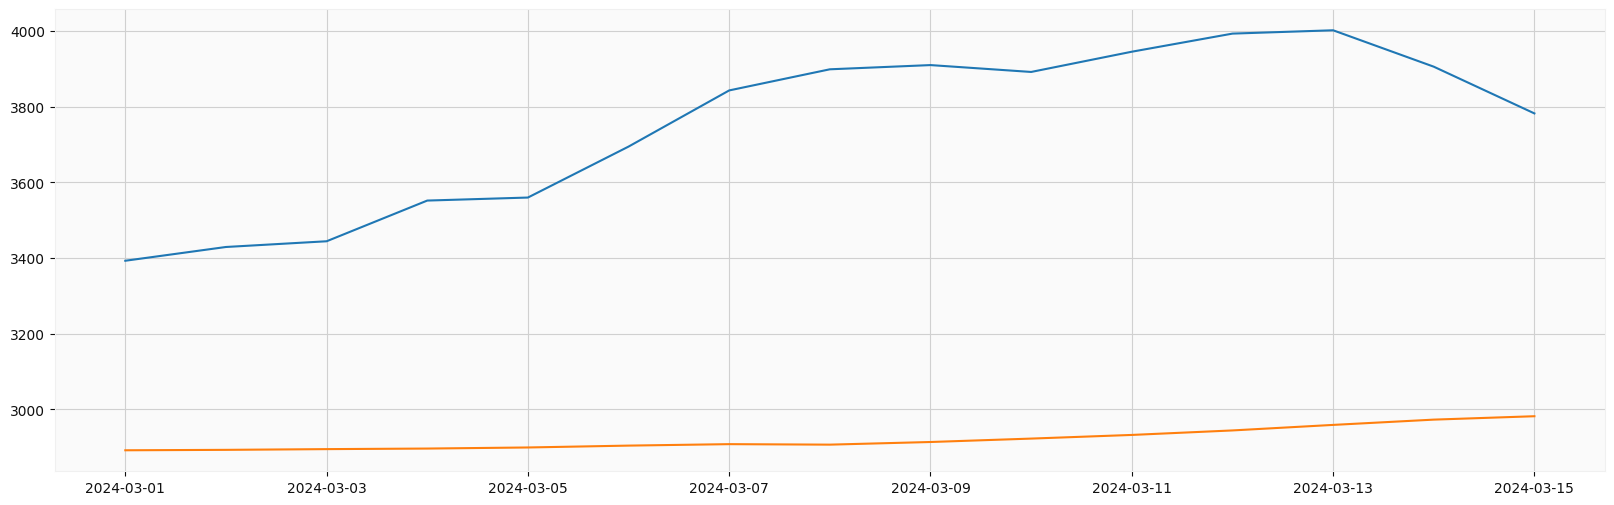

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(True_Predict['Date'], True_Predict['Actual Price'], label='Actual Price')
plt.plot(True_Predict['Date'], True_Predict['Predicted Price'], label='Predicted Price')